In [ ]:
from google.colab import files # чтобы загружать файлы в облако через проводник

In [ ]:
uploaded = files.upload() #просто запускаем и выбираем файл  API токена в проводнике

#↓ строка которая активирует наш API токен
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#↓ добавился восклицательный знак, потому что это колаб
!kaggle competitions download -c urfuaieng2022clf2

 89% 37.0M/41.4M [00:00<00:00, 49.7MB/s]
100% 41.4M/41.4M [00:01<00:00, 42.7MB/s]


Распаковываем архив "на месте"

In [ ]:
#↓ "распакуй" + имя архива
!unzip urfuaieng2022clf2.zip

Archive:  urfuaieng2022clf2.zip
  inflating: Submission_clf.csv      
  inflating: Test_Who.csv            
  inflating: Train_Target_clf.csv    
  inflating: Train_Who.csv           
  inflating: assessments.csv         
  inflating: courses.csv             
  inflating: studentInfo.csv         
  inflating: studentRegistration.csv  
  inflating: studentVle.csv          
  inflating: vle.csv                 


## Некоторые полезные функции для анализа табличек между собой

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from sklearn.metrics import classification_report # функция scikit-learn которая считает много метрик классификации
from sklearn.model_selection import StratifiedKFold # при кросс-валидации разбиваем данные в пропорции целевой метки
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import confusion_matrix # матрица ошибок от Scikit-learn
from sklearn.metrics import accuracy_score as acc # функция расчета доли правильных ответов от Scikit-learn
from sklearn.metrics import f1_score as f1 # функция расчета f1-меры от Scikit-learn

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
# альтернативно можно использовать StratifiedKFold т.к. задача классификации
import seaborn as sns # чтобы подкрасить таблички

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [ ]:
# данные которые "все"
ass = pd.read_csv('/content/assessments.csv')
courses = pd.read_csv('/content/courses.csv')
#results = pd.read_csv('/content/courses.csv')
info = pd.read_csv('/content/studentInfo.csv')
reg = pd.read_csv('/content/studentRegistration.csv')
vle = pd.read_csv('/content/studentVle.csv')
materials = pd.read_csv('/content/vle.csv')

## Assessments info (информация об оценках)

1. **code_module** – идентификационный код модуля, которому принадлежит оценка.
2. **code_presentation** - идентификационный код презентации, к которой относится оценка.
3. **id_assessment** – идентификационный номер оценки.
4. **assessment_type** – вид оценки. Существует три типа оценок: оцениваемая репетитором (TMA), компьютерная оцениваемая оценка (CMA) и итоговый экзамен (Exam).
5. **date** – информация об окончательной дате сдачи оценки, рассчитанная как количество дней с момента начала модуля-презентации. Дата начала презентации имеет номер 0 (ноль).
6. **weight** - вес оценки в %. Обычно Экзамены обрабатываются отдельно и имеют вес 100%; сумма всех остальных оценок равна 100%.

In [ ]:
ass.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
ass['id_assessment'] = ass['id_assessment'].astype(object)

In [ ]:
ass.head() # Метод .head() - первые 5 строк

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


## Courses info (информация о курсах)

1. **code_module** – кодовое имя модуля, которое служит идентификатором.
2. **code_presentation** – кодовое название презентации. Он состоит из года и «B» для презентации, начинающейся в феврале, и «J» для презентации, начинающейся в октябре.
3. **module_presentation_length** - длина модуля-презентации в днях.

In [ ]:
courses.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [ ]:
courses.head() # Метод .head() - первые 5 строк

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


## Student registration (регистрация студентов)

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код презентации.
3. **id_student** – уникальный идентификационный номер студента.
4. **date_registration** – дата регистрации студента на презентацию модуля, это количество дней, измеренное относительно начала презентации модуля (например, отрицательное значение -30 означает, что студент зарегистрировался на презентацию модуля за 30 дней до ее начала).

In [ ]:
reg.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        32593 non-null  object 
 1   code_presentation  32593 non-null  object 
 2   id_student         32593 non-null  int64  
 3   date_registration  32548 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1018.7+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
reg['id_student'] = reg['id_student'].astype(object)

In [ ]:
reg.head() # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-159.0
1,AAA,2013J,28400,-53.0
2,AAA,2013J,30268,-92.0
3,AAA,2013J,31604,-52.0
4,AAA,2013J,32885,-176.0


## VLE resources

1. **id_site** - идентификационный номер материала.
2. **code_module** – идентификационный код модуля.
3. **code_presentation** - идентификационный код презентации.
4. **activity_type** – роль, связанная с материалом модуля.
5. **week_from** – неделя, с которой планируется использовать материал.
6. **week_to** – неделя, до которой планируется использовать материал.

In [ ]:
materials.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
materials['id_site'] = materials['id_site'].astype(object)

In [ ]:
materials.head() # Метод .head() - первые 5 строк

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


## VLE Interactions

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код представления модуля.
3. **id_student** – уникальный идентификационный номер студента.
4. **id_site** - идентификационный номер материала VLE.
5. **date** – дата взаимодействия студента с материалом измеряется как количество дней с начала модуля-презентации.
6. **sum_click** – сколько раз учащийся взаимодействовал с материалом в этот день.

In [ ]:
vle.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB




```
487 MB, карл
```



Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
vle['id_student'] = vle['id_student'].astype(object)
vle['id_site'] = vle['id_site'].astype(object)

In [ ]:
vle.head() # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


## Student information

1. **code_module** – идентификационный код модуля, на котором зарегистрирован студент.
2. **code_presentation** - идентификационный код презентации, во время которой студент регистрируется на модуле.
3. **id_student** – уникальный идентификационный номер студента.
4. **gender** – пол ученика.
5. **region** – определяет географический регион, в котором студент проживал во время прохождения модуля-презентации.
6. **highest_education** – самый высокий уровень образования студента при поступлении на модульную презентацию.
7. **imd_band** – задает диапазон [Index of Multiple Depravation](https://en.wikipedia.org/wiki/Multiple_deprivation_index#:~:text=Indices%20of%20multiple%20deprivation%20(IMD,a%20single%20score%20of%20deprivation.) места, где студент проживал во время модуля-презентации. (насколько бедный район, короче)
8. **age_band** – диапазон студенческого возраста.
9. **num_of_prev_attempts** – количество раз, когда учащийся пытался пройти этот модуль.
10. **studied_credits** – общее количество кредитов по модулям, которые студент изучает в настоящее время.
11. **disability** – указывает, признан ли студент инвалидом.

In [ ]:
info.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
info['id_student'] = info['id_student'].astype(object)

In [ ]:
info.head()  # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N


Если мы просто смотрим что можно объединить (в плане признаков), то наверное лучше воспользоваться Inner Join (т.е. только то что есть в обоих фреймах)

А то еще кучу Nan потом заполнять

## Регистрация + Информация о курсах

In [ ]:
#                                     ↓ по каким колонкам буддем объединять     ↓ как
regCourses = pd.merge(reg, courses, on=['code_module', 'code_presentation'], how='inner')

regCourses.head()

,code_module,code_presentation,id_student,date_registration,module_presentation_length
0,AAA,2013J,11391,-159.0,268
1,AAA,2013J,28400,-53.0,268
2,AAA,2013J,30268,-92.0,268
3,AAA,2013J,31604,-52.0,268
4,AAA,2013J,32885,-176.0,268


## Регистрация + Информация о курсах + Инфа о студентах

In [ ]:
#                                     ↓ по каким колонкам буддем объединять                       ↓ как
regCoursesInfo = pd.merge(regCourses, info, on=['code_module', 'code_presentation', 'id_student'], how='inner')

regCoursesInfo.head()

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,-159.0,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,-53.0,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,-92.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,-52.0,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,-176.0,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N


In [ ]:
studentVle_df = vle.merge(materials, on = 'id_site', how = 'left')
studentInteractivity_df = studentVle_df[['id_student',
                                     'activity_type', 'sum_click']].groupby(['id_student', 'activity_type']).mean()
studentInteractivity_df = studentInteractivity_df.reset_index()
studentInteractivity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220871 entries, 0 to 220870
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_student     220871 non-null  int64  
 1   activity_type  220871 non-null  object 
 2   sum_click      220871 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.1+ MB


In [ ]:
studentInteractivity_df = studentInteractivity_df.pivot(index='id_student',
                                                    columns='activity_type', values='sum_click')
studentInteractivity_df = studentInteractivity_df.reset_index()
studentInteractivity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26074 entries, 0 to 26073
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_student      26074 non-null  int64  
 1   dataplus        2697 non-null   float64
 2   dualpane        3687 non-null   float64
 3   externalquiz    4685 non-null   float64
 4   folder          1934 non-null   float64
 5   forumng         23512 non-null  float64
 6   glossary        5978 non-null   float64
 7   homepage        26037 non-null  float64
 8   htmlactivity    1918 non-null   float64
 9   oucollaborate   10288 non-null  float64
 10  oucontent       24281 non-null  float64
 11  ouelluminate    2501 non-null   float64
 12  ouwiki          10402 non-null  float64
 13  page            8327 non-null   float64
 14  questionnaire   4476 non-null   float64
 15  quiz            18291 non-null  float64
 16  repeatactivity  3 non-null      float64
 17  resource        24896 non-null 

In [ ]:

def nan_values_handle(data):
  print("missing_values")
  print("data_shape :" ,data.shape)
  percent_missing = data.isnull().sum() * 100 / len(data)
  missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
  display(missing_value_df.sort_values(ascending=False,by="percent_missing")[:50])

  print("drop_cols_with_more_then_nan_values_0.25%")
  missing_data_high=missing_value_df["percent_missing"]>61
  display(missing_data_high[missing_data_high==True].index)

  drop_cols=missing_data_high[missing_data_high==True].index
  data.drop(drop_cols,axis=1,inplace=True)
  display(data.shape)
  return data

In [ ]:
studentInteractivity_df=nan_values_handle(studentInteractivity_df)

missing_values
data_shape : (26074, 21)


,column_name,percent_missing
activity_type,,
repeatactivity,repeatactivity,99.988494
sharedsubpage,sharedsubpage,99.512925
htmlactivity,htmlactivity,92.644013
folder,folder,92.582649
ouelluminate,ouelluminate,90.408069
dataplus,dataplus,89.656363
dualpane,dualpane,85.859477
questionnaire,questionnaire,82.833474
externalquiz,externalquiz,82.031909


drop_cols_with_more_then_nan_values_0.25%


Index(['dataplus', 'dualpane', 'externalquiz', 'folder', 'glossary',
       'htmlactivity', 'ouelluminate', 'page', 'questionnaire',
       'repeatactivity', 'sharedsubpage'],
      dtype='object', name='activity_type')

(26074, 10)

In [ ]:
#strategy_for_numerical_feature
df=studentInteractivity_df.copy()
imputer=KNNImputer(n_neighbors=5)
df=imputer.fit_transform(df)
studentInteractivity_df=pd.DataFrame(df,columns=studentInteractivity_df.columns)
studentInteractivity_df.head(2)

activity_type,id_student,forumng,homepage,oucollaborate,oucontent,ouwiki,quiz,resource,subpage,url
0,6516.0,2.577143,3.145570,1.280556,8.179348,4.055335,4.399264,1.631579,1.958904,2.918367
1,8462.0,1.809524,3.603774,1.625000,2.461538,3.600000,6.829697,1.372549,1.991228,1.352941


In [ ]:

studentInteractivity_df["Total"] = (
      studentInteractivity_df["forumng"]
    + studentInteractivity_df["homepage"]
    + studentInteractivity_df["oucontent"]
    + studentInteractivity_df["quiz"]
    + studentInteractivity_df["resource"]
    + studentInteractivity_df["subpage"]
    + studentInteractivity_df["url"]
    + studentInteractivity_df["ouwiki"]
    + studentInteractivity_df["oucollaborate"]
)
studentInteractivity_df.head(2)

activity_type,id_student,forumng,homepage,oucollaborate,oucontent,ouwiki,quiz,resource,subpage,url,Total
0,6516.0,2.577143,3.145570,1.280556,8.179348,4.055335,4.399264,1.631579,1.958904,2.918367,30.146066
1,8462.0,1.809524,3.603774,1.625000,2.461538,3.600000,6.829697,1.372549,1.991228,1.352941,24.646251


In [ ]:
studentInteractivity_df.columns[1:10]

Index(['forumng', 'homepage', 'oucollaborate', 'oucontent', 'ouwiki', 'quiz',
       'resource', 'subpage', 'url'],
      dtype='object', name='activity_type')

In [ ]:
studentInteractivity_df.drop(studentInteractivity_df.columns[1:10],axis=1,inplace=True)

In [ ]:
dataset=regCoursesInfo.merge(studentInteractivity_df, on = ['id_student'], how='left')

In [ ]:
vle['Click_Timing'] = ['Before' if date < 0 else 'After' for date in vle['date']]

vle['After_Clicks'] = np.where(vle['Click_Timing'] =='After',
                                                 vle['sum_click'], 0)

vle['Before_Clicks']= np.where(vle['Click_Timing'] =='Before',
                                                 vle['sum_click'], 0)

# Create a new dataframe by Grouping the columns

student_vle_merge_vle_group = vle.groupby(['code_module', 'code_presentation', 'id_student']
                                          ,as_index=False)[ 'After_Clicks', 'Before_Clicks'].sum()
dataset=dataset.merge(student_vle_merge_vle_group, on = ['id_student','code_module'	,'code_presentation'], how='right')

In [ ]:
vle = pd.read_csv('/content/studentVle.csv')

In [ ]:
studentVle_ = vle.merge(materials, on = ['id_site','code_module','code_presentation'], how = 'left')
studentVle_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10655280 entries, 0 to 10655279
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   code_module        object 
 1   code_presentation  object 
 2   id_student         int64  
 3   id_site            object 
 4   date               int64  
 5   sum_click          int64  
 6   activity_type      object 
 7   week_from          float64
 8   week_to            float64
dtypes: float64(2), int64(3), object(4)
memory usage: 812.9+ MB


In [ ]:
studentVle_['week_from_Timing'] = ['Before' if date < 0 else 'After' for date in vle['date']]

studentVle_['After_week_to'] = np.where(studentVle_['week_from_Timing'] =='After',
                                                 studentVle_['week_to'], 0)
# Create a new dataframe by Grouping the columns

student_vle_merge_vle_group_1 = studentVle_.groupby(['code_module', 'code_presentation', 'id_student']
                                          ,as_index=False)['After_week_to'].sum()

In [ ]:
dataset=dataset.merge(student_vle_merge_vle_group_1, on = ['id_student','code_module'	,'code_presentation'], how='right')

In [ ]:
df = info.merge(vle, on = ['id_student','code_module','code_presentation'], how = 'left')
df=df.merge(reg, on = ['id_student','code_module','code_presentation'], how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10658645 entries, 0 to 10658644
Data columns (total 15 columns):
 #   Column                Dtype  
---  ------                -----  
 0   code_module           object 
 1   code_presentation     object 
 2   id_student            object 
 3   gender                object 
 4   region                object 
 5   highest_education     object 
 6   imd_band              object 
 7   age_band              object 
 8   num_of_prev_attempts  int64  
 9   studied_credits       int64  
 10  disability            object 
 11  id_site               float64
 12  date                  float64
 13  sum_click             float64
 14  date_registration     float64
dtypes: float64(4), int64(2), object(9)
memory usage: 1.3+ GB


In [ ]:
df=df[["num_of_prev_attempts","studied_credits","sum_click","id_site","date","id_student",'code_module','code_presentation','date_registration']]

In [ ]:
group_1=df.groupby(['code_module', 'code_presentation', 'id_student'],as_index=False)["studied_credits"].sum()
group_1[:2]

,code_module,code_presentation,id_student,studied_credits
0,AAA,2013J,11391,47040
1,AAA,2013J,28400,25800


In [ ]:
group_2=df.groupby(['code_module', 'code_presentation', 'id_student'],as_index=False)["date_registration"].sum()
group_2[:2]

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-31164.0
1,AAA,2013J,28400,-22790.0


In [ ]:
oftional=group_1.merge(group_2, on = ['id_student','code_module','code_presentation'], how = 'left')
dataset=dataset.merge(oftional, on = ['id_student','code_module','code_presentation'], how = 'left')

In [ ]:
week_all=materials.week_from+materials.week_to
materials["week_all"]=week_all
week = materials.groupby(['code_module', 'code_presentation']).agg({'week_all':'sum'})
week.reset_index(inplace=True)
display(week[:2])
display(week.shape)
week.week_all.mean()
week.week_all[week.week_all==0]=week.week_all.mean()


,code_module,code_presentation,week_all
0,AAA,2013J,8.0
1,AAA,2014J,8.0


(22, 3)

In [ ]:
WeekVle= vle.merge(week, on = ['code_module','code_presentation'], how = 'left')
WeekVle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10655280 entries, 0 to 10655279
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   code_module        object 
 1   code_presentation  object 
 2   id_student         int64  
 3   id_site            int64  
 4   date               int64  
 5   sum_click          int64  
 6   week_all           float64
dtypes: float64(1), int64(4), object(2)
memory usage: 650.3+ MB


In [ ]:
group_3=WeekVle.groupby(['code_module', 'code_presentation', 'id_student'],as_index=False)["week_all"].sum()
group_3[:2]

,code_module,code_presentation,id_student,week_all
0,AAA,2013J,11391,1568.0
1,AAA,2013J,28400,3440.0


In [ ]:
dataset=dataset.merge(group_3, on = ['id_student','code_module','code_presentation'], how = 'left')

In [ ]:
student_ages = info[['id_student', 'age_band']].groupby(['id_student']).count().reset_index()
age= vle[["id_student"]].merge(student_ages, on = ['id_student'], how = 'left')

In [ ]:
group_4=age.groupby(['id_student'],as_index=False)["age_band"].sum()
group_4[:2]

,id_student,age_band
0,6516,662
1,8462,608


In [ ]:
dataset=dataset.merge(group_4, on = ['id_student'], how = 'left')

In [ ]:
def filling_missing_values(data):
  num_cols =data.select_dtypes(include=np.number).columns
  cat_cols = data.columns[data.dtypes == 'object']
  print(print("size_of_num_and_cat_cols" ), len(num_cols),len(cat_cols))
  percent_missing = data.isnull().sum() * 100 / len(data)
  missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
  #print("cat_cols_missing_percentage")
  #display(missing_value_df.loc[cat_cols].sort_values(ascending=False,by="percent_missing")[:10])

  miss_cat=missing_value_df.loc[cat_cols][percent_missing!=0]
  miss_num=missing_value_df.loc[num_cols][percent_missing!=0]
  print("filling_columns_cat")
  display(miss_cat)
  print("filling_columns_num")
  display(miss_num)
  #strategy_for_categorial_feature
  imputer = SimpleImputer(strategy='most_frequent',missing_values=np.nan)
  data[miss_cat.index]=imputer.fit_transform(data[miss_cat.index])

  #strategy_for_numerical_feature
  imputer=KNNImputer(n_neighbors=5)
  data[num_cols]=imputer.fit_transform(data[num_cols])
  return data


In [ ]:
new_df=dataset.copy()
new_df.drop("date_registration_x",axis=1,inplace=True)
new_df=filling_missing_values(new_df)

size_of_num_and_cat_cols
None 11 9
filling_columns_cat


,column_name,percent_missing
imd_band,imd_band,3.606131


filling_columns_num


,column_name,percent_missing


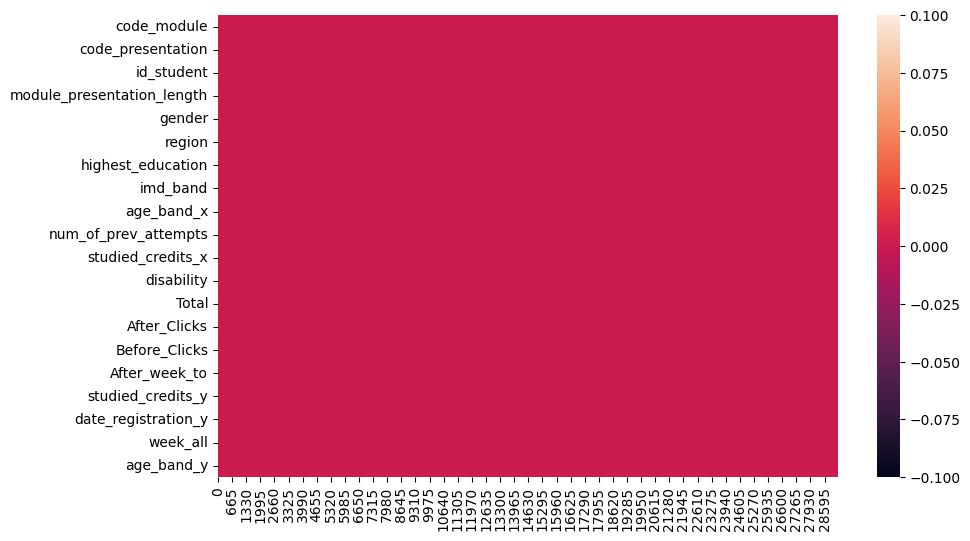

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(new_df.isna().transpose());

# Выделение тренировочной и тестовой выборки

Список студентов, соответсвующих модулей и презентаций (разные студенты могут сдавать разные модули)

In [ ]:
Train_Who = pd.read_csv('/content/Train_Who.csv')
Test_Who = pd.read_csv('/content/Test_Who.csv')

А вот тут Left Join по всему содержимому `Train_Who`

Потому что мы не хотим ничего упустить оттуда

In [ ]:
#                                               ↓ по каким колонкам буддем объединять               ↓ как
Train = pd.merge(Train_Who, new_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Train.index = Train.ID
# удаляем как столбец, ибо зачем
Train.drop(columns = ['ID'], inplace = True)
Train.head()

,id_student,code_module,code_presentation,module_presentation_length,gender,region,highest_education,imd_band,age_band_x,num_of_prev_attempts,studied_credits_x,disability,Total,After_Clicks,Before_Clicks,After_week_to,studied_credits_y,date_registration_y,week_all,age_band_y
ID,,,,,,,,,,,,,,,,,,,,
0,464685,DDD,2014B,241.0,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1.0,70.0,N,32.423207,1619.0,75.0,0.0,41650.0,-21420.0,922250.0,595.0
1,606593,DDD,2013J,261.0,M,Scotland,A Level or Equivalent,20-30%,0-35,0.0,120.0,N,19.940901,634.0,58.0,0.0,39240.0,-10464.0,506850.0,327.0
2,1674799,CCC,2014J,269.0,M,South Region,HE Qualification,70-80%,55<=,0.0,60.0,N,31.686021,1881.0,82.0,85.0,38460.0,-13461.0,26922.0,2756.0
3,195246,FFF,2014J,269.0,M,West Midlands Region,Lower Than A Level,10-20,0-35,0.0,60.0,N,29.328304,1931.0,207.0,856.0,43140.0,-89156.0,6335828.0,719.0
4,582080,FFF,2013J,268.0,M,South East Region,Lower Than A Level,10-20,35-55,0.0,60.0,N,23.105579,88.0,100.0,0.0,4920.0,-9348.0,779984.0,82.0


In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 0 to 26073
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_student                  26074 non-null  object 
 1   code_module                 26074 non-null  object 
 2   code_presentation           26074 non-null  object 
 3   module_presentation_length  23364 non-null  float64
 4   gender                      23364 non-null  object 
 5   region                      23364 non-null  object 
 6   highest_education           23364 non-null  object 
 7   imd_band                    23364 non-null  object 
 8   age_band_x                  23364 non-null  object 
 9   num_of_prev_attempts        23364 non-null  float64
 10  studied_credits_x           23364 non-null  float64
 11  disability                  23364 non-null  object 
 12  Total                       23364 non-null  float64
 13  After_Clicks                233

In [ ]:
Train=filling_missing_values(Train)

size_of_num_and_cat_cols
None 11 9
filling_columns_cat


,column_name,percent_missing
gender,gender,10.393495
region,region,10.393495
highest_education,highest_education,10.393495
imd_band,imd_band,10.393495
age_band_x,age_band_x,10.393495
disability,disability,10.393495


filling_columns_num


,column_name,percent_missing
module_presentation_length,module_presentation_length,10.393495
num_of_prev_attempts,num_of_prev_attempts,10.393495
studied_credits_x,studied_credits_x,10.393495
Total,Total,10.393495
After_Clicks,After_Clicks,10.393495
Before_Clicks,Before_Clicks,10.393495
After_week_to,After_week_to,10.393495
studied_credits_y,studied_credits_y,10.393495
date_registration_y,date_registration_y,10.393495
week_all,week_all,10.393495


аналогично для тестовой выборки

In [ ]:
#                                               ↓ по каким колонкам буддем объединять               ↓ как
Test = pd.merge(Test_Who, new_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Test.index = Test.ID
# удаляем как столбец, ибо зачем
Test.drop(columns = ['ID'], inplace = True)
Test.head()

,id_student,code_module,code_presentation,module_presentation_length,gender,region,highest_education,imd_band,age_band_x,num_of_prev_attempts,studied_credits_x,disability,Total,After_Clicks,Before_Clicks,After_week_to,studied_credits_y,date_registration_y,week_all,age_band_y
ID,,,,,,,,,,,,,,,,,,,,
26074,2588655,DDD,2014J,262.0,M,Scotland,Lower Than A Level,50-60%,0-35,2.0,60.0,N,31.696477,297.0,0.0,0.0,2820.0,-4324.0,72850.0,176.0
26075,543628,CCC,2014B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26076,387276,BBB,2013B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26077,692219,CCC,2014J,269.0,M,South Region,A Level or Equivalent,20-30%,0-35,0.0,90.0,N,26.886047,278.0,5.0,40.0,8100.0,-3060.0,3780.0,352.0
26078,516212,BBB,2013J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Test=filling_missing_values(Test)

size_of_num_and_cat_cols
None 11 9
filling_columns_cat


,column_name,percent_missing
gender,gender,10.047553
region,region,10.047553
highest_education,highest_education,10.047553
imd_band,imd_band,10.047553
age_band_x,age_band_x,10.047553
disability,disability,10.047553


filling_columns_num


,column_name,percent_missing
module_presentation_length,module_presentation_length,10.047553
num_of_prev_attempts,num_of_prev_attempts,10.047553
studied_credits_x,studied_credits_x,10.047553
Total,Total,10.047553
After_Clicks,After_Clicks,10.047553
Before_Clicks,Before_Clicks,10.047553
After_week_to,After_week_to,10.047553
studied_credits_y,studied_credits_y,10.047553
date_registration_y,date_registration_y,10.047553
week_all,week_all,10.047553


In [ ]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6519 entries, 26074 to 32592
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_student                  6519 non-null   object 
 1   code_module                 6519 non-null   object 
 2   code_presentation           6519 non-null   object 
 3   module_presentation_length  6519 non-null   float64
 4   gender                      6519 non-null   object 
 5   region                      6519 non-null   object 
 6   highest_education           6519 non-null   object 
 7   imd_band                    6519 non-null   object 
 8   age_band_x                  6519 non-null   object 
 9   num_of_prev_attempts        6519 non-null   float64
 10  studied_credits_x           6519 non-null   float64
 11  disability                  6519 non-null   object 
 12  Total                       6519 non-null   float64
 13  After_Clicks                

In [ ]:
Target = pd.read_csv('/content/Train_Target_clf.csv', index_col = 'ID')

df=pd.concat([Train,Target],axis=1)
display(df.head(2))

num_cols =df.select_dtypes(include=np.number).columns
cat_cols = df.columns[df.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

df=df[num_cols]

corr_df=pd.DataFrame(df.corr()["final_result"].sort_values(ascending=False)[:15])
corr_df.style.background_gradient(cmap='Blues')

,id_student,code_module,code_presentation,module_presentation_length,gender,region,highest_education,imd_band,age_band_x,num_of_prev_attempts,studied_credits_x,disability,Total,After_Clicks,Before_Clicks,After_week_to,studied_credits_y,date_registration_y,week_all,age_band_y,final_result
ID,,,,,,,,,,,,,,,,,,,,,
0,464685,DDD,2014B,241.0,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1.0,70.0,N,32.423207,1619.0,75.0,0.0,41650.0,-21420.0,922250.0,595.0,1
1,606593,DDD,2013J,261.0,M,Scotland,A Level or Equivalent,20-30%,0-35,0.0,120.0,N,19.940901,634.0,58.0,0.0,39240.0,-10464.0,506850.0,327.0,0


We have 12 numeric columns: module_presentation_length, num_of_prev_attempts, studied_credits_x, Total, After_Clicks, Before_Clicks, After_week_to, studied_credits_y, date_registration_y, week_all, age_band_y, final_result
And 9 categorical columns: id_student, code_module, code_presentation, gender, region, highest_education, imd_band, age_band_x, disability


,final_result
final_result,1.000000
After_Clicks,0.418044
studied_credits_y,0.381599
After_week_to,0.266552
age_band_y,0.253511
week_all,0.224300
Before_Clicks,0.153907
Total,0.098790
module_presentation_length,0.046479
num_of_prev_attempts,-0.099082


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

# Целевая переменная

Для регрессии - это взешенная оценка отдельного **студента** за конкретную **презентацию** по конкретному **модулю**

In [ ]:
Train.drop(columns = ['id_student'], inplace = True)
Test.drop(columns = ['id_student'], inplace = True)

ружьё Чехова (не Бондурчука)

пригодилось то, что мы все id-шники закинули в тип данных `object`

теперь можем "автоматически" выполнять предварительную обработку по колонкам

In [ ]:


num_cols =Train.select_dtypes(include=np.number).columns
cat_cols = Train.columns[Train.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")


We have 11 numeric columns: module_presentation_length, num_of_prev_attempts, studied_credits_x, Total, After_Clicks, Before_Clicks, After_week_to, studied_credits_y, date_registration_y, week_all, age_band_y
And 8 categorical columns: code_module, code_presentation, gender, region, highest_education, imd_band, age_band_x, disability


## наш старый друг Pipeline

In [ ]:
from sklearn.impute import SimpleImputer # Объект для замены пропущенных значений

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Импортируем нормализацию и One-Hot Encoding от scki-kit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

Создаем объект `Pipeline`

На вход ему подаем список из того, что мы хотим объединить в формате
* строка- название (даем имя Объекту)
* и сам объект (с заданными аргументами, если необходимо)

Сначала создадим отдельно Pipeline для числовых данных (вставление пропусков + нормализация)

In [ ]:
numerical_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('power', PowerTransformer()),
    ('scaler',   StandardScaler())
])

Предобработка категориальных данных (вставление пропусков + One-Hot кодирование)

In [ ]:
categorical_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='most_frequent', )),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

Объект `ColumnTransformer` имеет в целом схожий синтаксис с `Pipeline`

т.е. на вход ему также подаем список из того, что мы хотим объединить в формате

* строка- название (даем имя Объекту)
* сам объект (в этом случае подаем объекты Pipeline)
* добавляется еще список названий столбцов, к которым мы применяем эти преобразования


In [ ]:
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

"Обучаем" стандартно через `.fit()`

Тут важно, что на вход мы подаем датафреймы, т.к. в них есть колонки к которым мы обращаемся "по именам". Внимательно следите за названиями колонок, он проверяет всё добуквенно

In [ ]:
preprocessors.fit(Train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('poly',
                                                  PolynomialFeatures(degree=1)),
                                                 ('power', PowerTransformer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['module_presentation_length', 'num_of_prev_attempts',
       'studied_credits_x', 'Total', 'After_Clicks', 'Before_Clicks',
       'After_week_to', 'studied_credits_y', 'date_registration_y', 'week_all',
       'age_band_y'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['code_module', 'code_presentation', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band_x', 'disability'],
      dtype='object'))])

In [ ]:
X_train = preprocessors.transform(Train) # преобразуем  тренировочные данные

X_test = preprocessors.transform(Test) # преобразуем  тестовые данные

In [ ]:
sel_= SelectFromModel(Lasso(alpha=0.005,random_state=0))
# train Lasso model and select features
sel_.fit(X_train,Target)
# let's print the number of total and selected features

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [ ]:
# let's print the number of total and selected features
selected_feats = pd.DataFrame(X_train).columns[(sel_.get_support())]
# let's print some stats
print('Total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_== 0)))

Total features: 56
selected features: 20
features with coefficients shrank to zero: 36


In [ ]:
pd.DataFrame(X_train).iloc[:,selected_feats]

,1,2,3,4,5,6,7,8,9,10,13,14,16,17,19,23,30,38,39,44
0,-1.211715,2.283324,-0.011320,0.875273,0.624142,0.614530,-1.214124,0.776954,0.022719,0.670494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.250858,-0.512870,1.200280,-1.576031,-0.125805,0.452545,-1.214124,0.717622,0.388374,0.398992,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1.135241,-0.512870,-0.363232,0.765293,0.762815,0.672162,0.405020,0.697831,0.283577,-0.729875,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.135241,-0.512870,-0.363232,0.391190,0.787653,1.314144,1.154872,0.812354,-1.815030,1.657385,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.012966,-0.512870,-0.363232,-0.805048,-1.198337,0.802949,-1.214124,-0.888451,0.428690,0.592939,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26069,1.135241,-0.512870,-0.363232,0.736275,1.569796,2.712888,0.005798,1.389221,-3.745939,-1.050844,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
26070,0.350268,-0.512870,1.200280,0.968182,-2.273417,0.257521,-1.214124,-1.737213,0.808458,-1.456732,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26071,-1.263307,2.293203,-0.363232,-0.394027,-1.631253,-1.538629,-1.214124,-1.737213,0.739082,-0.801031,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
26072,0.250858,-0.512870,-0.363232,-0.166972,0.623582,0.937663,-1.214124,0.816567,-2.600040,0.761599,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
X_train=pd.DataFrame(X_train).iloc[:,selected_feats]
X_test=pd.DataFrame(X_test).iloc[:,selected_feats]

In [ ]:
X_train.shape

(26074, 20)

In [ ]:
X_test.shape

(6519, 20)

In [ ]:
from sklearn.ensemble import  RandomForestClassifier
from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = LogisticRegression()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, Target, test_size=0.2, random_state=42)

In [ ]:

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_val.shape)
print('Testing Labels Shape:', y_val.shape)

Training Features Shape: (20859, 20)
Training Labels Shape: (20859, 1)
Testing Features Shape: (5215, 20)
Testing Labels Shape: (5215, 1)


In [ ]:

pipeline = Pipeline(steps=[
    ('model',  ClfSwitcher())
])

In [ ]:
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(1, 150, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 40, num = 41)]
#max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 60, num = 15)]
# Method of selecting samples for training each tree
bootstrap = [True, False]


parameters = [
  {
        'model': (RandomForestClassifier(),),
        'model__n_estimators': n_estimators,
        'model__max_features': max_features,
        'model__max_depth': max_depth,
        'model__min_samples_leaf': min_samples_leaf,
        'model__bootstrap': bootstrap,
    }
]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters,
                              n_iter = 100, scoring='f1',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_random.best_params_


{'model__n_estimators': 107,
 'model__min_samples_leaf': 1,
 'model__max_features': 'auto',
 'model__max_depth': 18,
 'model__bootstrap': True,
 'model': RandomForestClassifier(max_depth=18, max_features='auto', n_estimators=107)}

In [ ]:
#best=RandomForestClassifier(bootstrap=False, max_depth=34, max_features='auto',n_estimators=139)

In [ ]:
best=rf_random.best_estimator_
best.fit(X_train, y_train)

y_predict=best.predict(X_val)

scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

scores = cross_validate(best, X_train, y_train,
                      scoring=scoring, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42))


print('Результаты Кросс-валидации')
DF_cv = pd.DataFrame(scores)
display(DF_cv)
print('\n')
print(DF_cv.mean()[2:])

print(classification_report(y_val, y_predict, target_names=['yes','no']))

Результаты Кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,2.945628,0.129430,0.854986,0.854462,0.812815,0.900609
1,2.971294,0.128190,0.863854,0.861868,0.827651,0.899036
2,3.676654,0.173175,0.850671,0.850132,0.808326,0.896499
3,3.145443,0.128659,0.869128,0.868116,0.828492,0.911720
4,2.986017,0.130398,0.852793,0.850681,0.816908,0.887367




test_ACC          0.858286
test_F1           0.857052
test_Precision    0.818838
test_Recall       0.899046
dtype: float64
              precision    recall  f1-score   support

         yes       0.90      0.83      0.86      2758
          no       0.82      0.89      0.86      2457

    accuracy                           0.86      5215
   macro avg       0.86      0.86      0.86      5215
weighted avg       0.86      0.86      0.86      5215



In [ ]:
from sklearn.svm import SVC # for Support Vector Classification model

parameters = [
	{"kernel":["poly"],
		"degree": [2],
		"C":  np.logspace(-2, 1, 7)},
	{"kernel":["rbf"],
		"gamma": ["auto"],
		"C":  np.logspace(-2, 1, 7)}]

# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=SVC(), param_distributions=parameters,
                              n_iter = 100, scoring='f1',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);


Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [ ]:
rf_random.best_params_


{'kernel': 'rbf', 'gamma': 'auto', 'C': 3.1622776601683795}

In [ ]:
#{'kernel': 'rbf', 'gamma': 'auto', 'C': 2.154434690031882}
#SVC(kernel="rbf",gamma="auto",C=2.154434690031882,probability=True, class_weight="balanced")

In [ ]:
from sklearn.svm import SVC # for Support Vector Classification model
best=SVC(kernel="rbf",gamma="auto",C= 3.1622776601683795,probability=True, class_weight="balanced")
best.fit(X_train, y_train)

y_predict=best.predict(X_val)

scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

scores = cross_validate(best, X_train, y_train,
                      scoring=scoring, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42))


print('Результаты Кросс-валидации')
DF_cv = pd.DataFrame(scores)
display(DF_cv)
print('\n')
print(DF_cv.mean()[2:])

print(classification_report(y_val, y_predict, target_names=['yes','no']))

Результаты Кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,9.924648,1.505919,0.859540,0.859876,0.813575,0.911765
1,9.279587,3.709201,0.867210,0.866570,0.824851,0.912735
2,15.034582,2.496787,0.849712,0.850963,0.800537,0.908168
3,10.862180,1.566062,0.872963,0.873930,0.822660,0.932014
4,9.051948,1.510877,0.854711,0.854187,0.812357,0.900558




test_ACC          0.860827
test_F1           0.861105
test_Precision    0.814796
test_Recall       0.913048
dtype: float64
              precision    recall  f1-score   support

         yes       0.90      0.82      0.86      2758
          no       0.82      0.90      0.86      2457

    accuracy                           0.86      5215
   macro avg       0.86      0.86      0.86      5215
weighted avg       0.86      0.86      0.86      5215



In [ ]:
#{'kernel': 'rbf', 'gamma': 'auto', 'C': 2.154434690031882}
best=SVC(kernel="rbf",gamma="auto",C=2.154434690031882,probability=True, class_weight="balanced")
best.fit(X_train,y_train)
def custom_predict(X, threshold):
    probs = best.predict_proba(X_val)
    return (probs[:, 1] > threshold).astype(int)


new_preds = custom_predict(X_val, threshold=0.38)
f1(y_val,new_preds)


0.8590986879634912

#voting+ramdom_search

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,normalize=False):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [ ]:
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

In [ ]:
import xgboost as xgb
xgb_cfl =xgb.XGBClassifier(n_jobs = -1)
param_grid = {
            'n_estimators': [100, 200, 300, 400]
              }

CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, scoring ='f1', verbose = 2)
CV_xgb_cfl.fit(X_train, y_train)

best_parameters = CV_xgb_cfl.best_params_
print("The best parameters for using this model is", best_parameters)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...................................n_estimators=100; total time=   3.5s
[CV] END ...................................n_estimators=100; total time=   2.8s
[CV] END ...................................n_estimators=100; total time=   2.7s
[CV] END ...................................n_estimators=100; total time=   4.7s
[CV] END ...................................n_estimators=100; total time=   2.7s
[CV] END ...................................n_estimators=200; total time=   7.7s
[CV] END ...................................n_estimators=200; total time=   6.8s
[CV] END ...................................n_estimators=200; total time=   5.5s
[CV] END ...................................n_estimators=200; total time=   7.0s
[CV] END ...................................n_estimators=200; total time=   7.3s
[CV] END ...................................n_estimators=300; total time=   7.9s
[CV] END ...................................n_est

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,normalize=False):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')


def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

<Figure size 640x480 with 0 Axes>

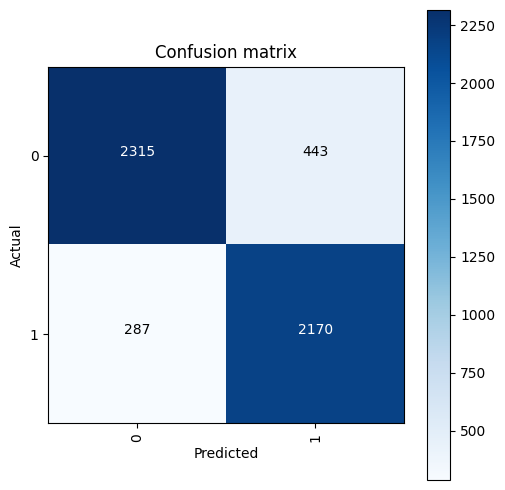

Precision =     0.830
Recall    =     0.883
F1_score  =     0.856


In [ ]:
# xgb
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 100)

xgb_cfl.fit(X_train, y_train)
y_pred = xgb_cfl.predict(X_val)
y_score = xgb_cfl.predict_proba(X_val)[:,1]

# Confusion maxtrix & metrics
cm = confusion_matrix(y_val, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm,
                      classes = class_names, )
plt.savefig('2.xgb_cfl_confusion_matrix.png')
plt.show()

show_metrics()



In [ ]:
len(xgb_cfl.feature_importances_)

20

In [ ]:
X_train_1=pd.DataFrame(X_train)

In [ ]:
#feature importance plot
def plot_feature_importance(model):
    tmp = pd.DataFrame({'Feature': X_train_1.columns, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (10,8))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

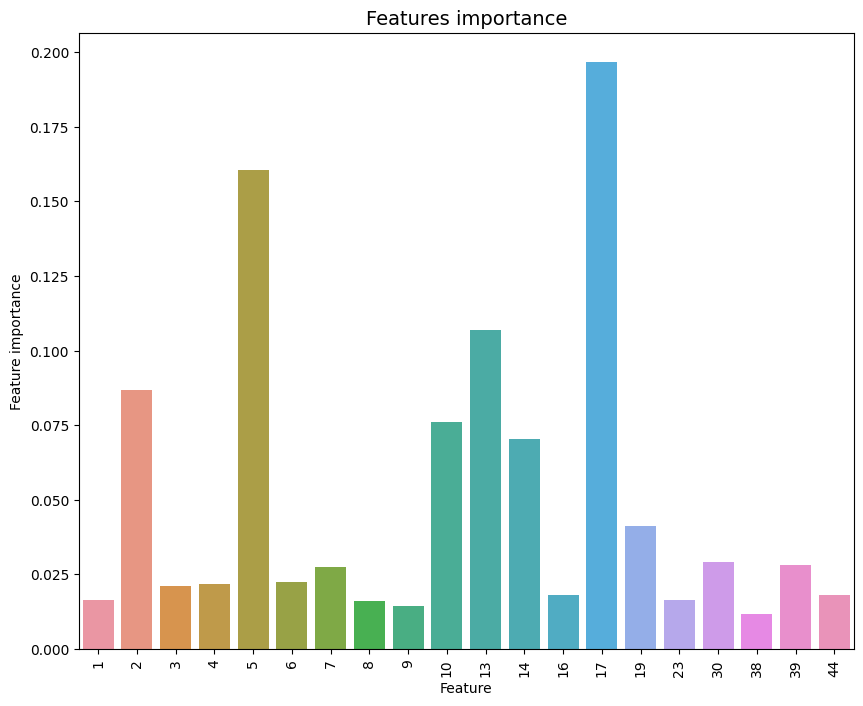

In [ ]:
plot_feature_importance(xgb_cfl)

#max_threshold+logistic_regression

In [ ]:

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold


    def threshold_from_optimal_f_score(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        fscores = (2 * precisions * recalls) / (precisions + recalls)

        optimal_idx = np.argmax(fscores)

        return thresholds[optimal_idx], fscores[optimal_idx]

In [ ]:

lrt = LogisticRegressionWithThreshold()
lrt.fit(X_train, y_train)

threshold, optimal_f1_score = lrt.threshold_from_optimal_f_score(X_train, y_train)
y_pred = lrt.predict(X_val, threshold)

threshold, optimal_f1_score

(0.35834273969684727, 0.8498591549295774)

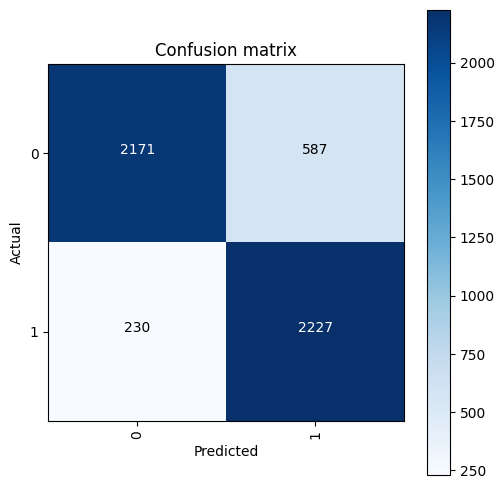

In [ ]:
plot_confusion_matrix(confusion_matrix(y_val,y_pred>threshold),classes=["0","1"])


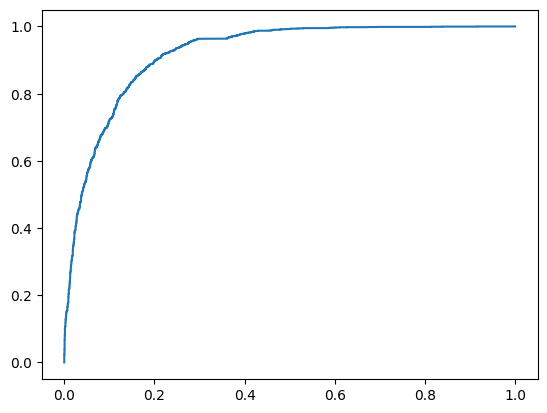

In [ ]:
fpr,tpr,_ =roc_curve(y_val,lrt.predict_proba(X_val)[:,1])
plt.plot(fpr,tpr)

In [ ]:
from sklearn.ensemble import VotingClassifier

<Figure size 640x480 with 0 Axes>

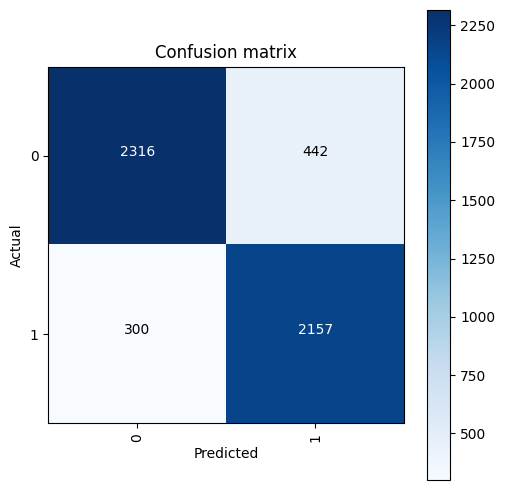

Precision =     0.830
Recall    =     0.878
F1_score  =     0.853


In [ ]:
voting_cfl = VotingClassifier (
        estimators = [('xgb', xgb_cfl), ('lt', lrt), ('rf', best)],
                     voting='soft', weights = [1, 1, 1.33])

voting_cfl.fit(X_train,y_train)

y_pred = voting_cfl.predict(X_val)
y_score = voting_cfl.predict_proba(X_val)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_val, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm,
                      classes = class_names, )
plt.savefig('1.voting_confusion_matrix.png')
plt.show()

show_metrics()

In [ ]:

predict=best.predict(X_test)

In [ ]:
Submission = pd.read_csv('/content/Submission_clf.csv', index_col = 'ID')

In [ ]:
Submission.shape

(6519, 1)

In [ ]:
Submission['final_result'] = predict

In [ ]:
Submission.to_csv('/content/My_Submission_clf_3.csv',index=True) # если хотим чтобы и индексы сохранились - пишем index = True

In [ ]:
!kaggle competitions submit -c urfuaieng2022clf2 -f My_Submission_clf_3.csv -m " clf test"

100% 50.9k/50.9k [00:00<00:00, 120kB/s]
Successfully submitted to UrFU_AI_Eng_2022_Clf_2